In [21]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    custom_plots,
)
from ripple_heterogeneity.assembly import assembly_reactivation,find_sig_assembly
from ripple_heterogeneity.readout import ca1_assembly_downstream_psth, assembly_multi_region
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats

from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## locate sessions with pfc or mec

In [22]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA10\day12
1,Z:\Data\AYAold\AYA7\day19
2,Z:\Data\AYAold\AYA7\day20
3,Z:\Data\AYAold\AYA7\day24
4,Z:\Data\AYAold\AYA7\day25
...,...
114,Z:\Data\Kenji\i01_maze15_MS.001_004
115,Z:\Data\Kenji\nlx_070329
116,Z:\Data\ORproject\OR18\day1
117,Z:\Data\ORproject\OR18\day2


## Main analysis

locate ca1 assemblies that are all deep or all superficial and look at the psth of cortical response to moments when the strength is high in ripples

In [23]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\ca1_assembly_downstream_psth_v3"
)

batch_analysis.run(
    sessions,
    save_path,
    ca1_assembly_downstream_psth.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
(
    pre_deep,
    task_deep,
    post_deep,
    pre_sup,
    task_sup,
    post_sup,
    meta_data_deep,
    meta_data_sup,
) = ca1_assembly_downstream_psth.load_results(save_path)


100%|██████████| 119/119 [00:04<00:00, 24.74it/s]


Loading results...


## figure helpers

In [24]:
from scipy.ndimage import gaussian_filter1d


def plot_psth_matrix(
    psth_df, cell_metrics, region_idx, label=None, ax=None, vmax=3, vmin=-3
):

    psth = psth_df.values[:, cell_metrics.brainRegion.str.contains(region_idx).values]
    
    psth = psth[:,~np.isnan(psth).any(axis=0)]

    psth_smooth = gaussian_filter1d(
        psth, np.round(0.020 / np.diff(psth_df.index)[0]), axis=0
    )
    # psth_smooth = psth
    max_mean_ratio = psth_smooth[(psth_df.index > 0) & (psth_df.index < 0.1), :].max(
        axis=0
    ) / psth_smooth[(psth_df.index < -0.10), :].mean(axis=0)

    sort_idx = np.argsort(max_mean_ratio)

    if ax is None:
        plt.figure()
    ax = plt.gca()

    extent = [psth_df.index.min(), psth_df.index.max(), 0, psth.shape[1]]

    sm = ax.imshow(
        stats.zscore(psth_smooth, axis=0)[:, sort_idx].T,
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap="bwr",
    )

    ax.set_yticks([psth.shape[1]])

    ax.axvline(0, color="k", lw=1, ls="--")
    if label is not None:
        ax.set_title(label, fontsize=12)
    return sm
    
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper
    
def std_upper_lower(X):
    upper = np.nanmean(X,axis=1) + np.nanstd(X,axis=1)
    lower = np.nanmean(X,axis=1) - np.nanstd(X,axis=1)
    return lower,upper

## plot big psth

Text(0.5, 1.0, 'PFC psth to sup assembly')

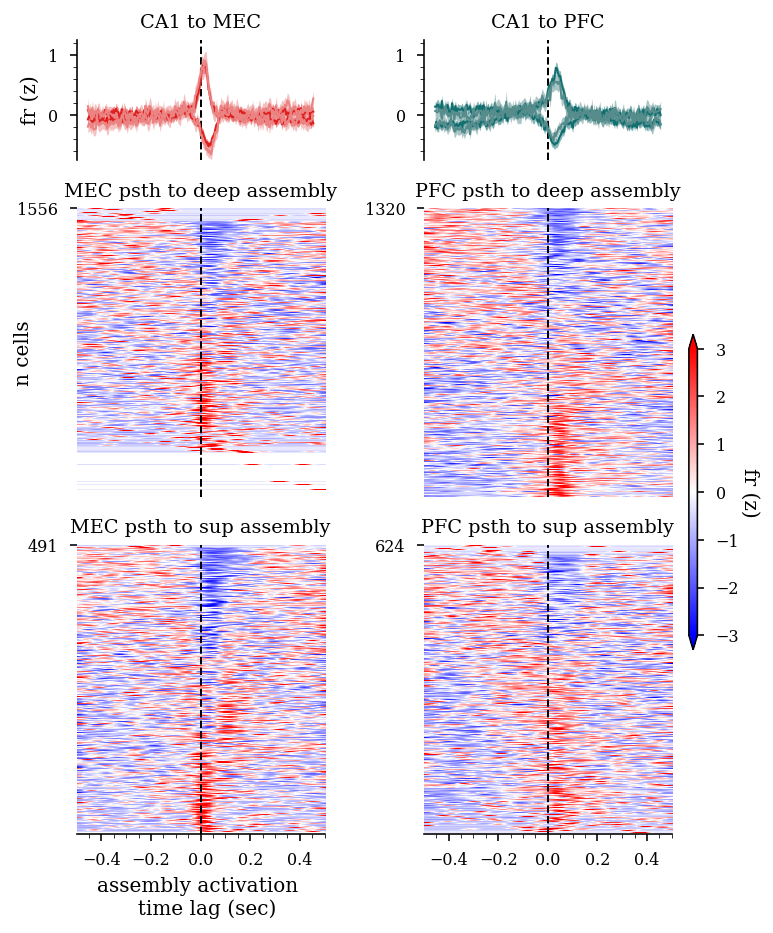

In [25]:
def get_center_val(
    psth_df, cell_metrics, brain_region, window=[0, 0.05], smooth_sigma=0.02
):
    # find cells within region
    psth = psth_df.values[:, cell_metrics.brainRegion.str.contains(brain_region).values]
    # standardize psth
    psth = stats.zscore(psth, axis=0)
    # smooth over time
    psth_smooth = gaussian_filter1d(
        psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
    )
    # pull out data within time window
    X = psth_smooth[(psth_df.index > window[0]) & (psth_df.index < window[1]), :]
    # find center value of each cell, can be positive or negative, but will be max magnitude
    center_val = [X[np.argmax(np.abs(X[:, i])), i] for i in range(X.shape[1])]
    return np.array(center_val)


def plot_psth_postive_negative(
    psth_df,
    cell_metrics,
    brain_region,
    group_label,
    group_colors,
    ax0,
    plot_neg=True,
    return_mean=False,
    smooth_sigma=None,
):
    if smooth_sigma is not None:
        psth_df[:] = gaussian_filter1d(
            psth_df.values, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
        )
    center_val = get_center_val(psth_df, cell_metrics, brain_region)

    # plot positive psth responses
    psth = psth_df.values[:, cell_metrics.brainRegion.str.contains(brain_region).values]
    psth = psth[:, center_val > 0]
    psth = stats.zscore(psth, axis=0)
    lower, upper = confidence_intervals(psth.T)
    ax0.plot(
        psth_df.index,
        np.nanmean(psth, axis=1),
        color=group_colors[group_label],
        linewidth=1,
    )
    ax0.fill_between(
        psth_df.index,
        lower,
        upper,
        color=group_colors[group_label],
        alpha=0.5,
        linewidth=0,
    )

    if return_mean:
        pos_mean = np.nanmean(psth, axis=1)

    # plot negative psth responses
    if plot_neg:
        psth = psth_df.values[
            :, cell_metrics.brainRegion.str.contains(brain_region).values
        ]
        psth = psth[:, center_val < 0]
        psth = stats.zscore(psth, axis=0)
        lower, upper = confidence_intervals(psth.T)
        ax0.plot(
            psth_df.index,
            np.nanmean(psth, axis=1),
            color=group_colors[group_label],
            linewidth=1,
        )
        ax0.fill_between(
            psth_df.index,
            lower,
            upper,
            color=group_colors[group_label],
            alpha=0.5,
            linewidth=0,
        )
    if return_mean & plot_neg:
        neg_mean = np.nanmean(psth, axis=1)

    if return_mean & plot_neg:
        return pos_mean, neg_mean
    elif return_mean:
        return pos_mean


group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=1, subplots=(4, 2)),
    constrained_layout=False,
)
gs = fig.add_gridspec(nrows=5, ncols=2, left=0.05, right=0.75, hspace=0.4, wspace=0.4)

y_min = -0.75
y_max = 1.25
heatmap_factor = 2

ax0 = fig.add_subplot(gs[0, 0])
plot_psth_postive_negative(
    post_deep, meta_data_deep, "EC1|EC2|EC3|EC4|EC5|MEC", "deep_mec", group_colors, ax0
)
plot_psth_postive_negative(
    post_sup, meta_data_sup, "EC1|EC2|EC3|EC4|EC5|MEC", "sup_mec", group_colors, ax0
)

ax1 = fig.add_subplot(gs[0, 1])
plot_psth_postive_negative(
    post_deep, meta_data_deep, "PFC", "deep_pfc", group_colors, ax1
)
plot_psth_postive_negative(post_sup, meta_data_sup, "PFC", "sup_pfc", group_colors, ax1)

ax2 = fig.add_subplot(gs[1:3, 0])
plot_psth_matrix(
    post_deep,
    meta_data_deep,
    "EC1|EC2|EC3|EC4|EC5|MEC",
    label=None,
    ax=ax2,
    vmax=3,
    vmin=-3,
)

ax3 = fig.add_subplot(gs[1:3, 1])
plot_psth_matrix(post_deep, meta_data_deep, "PFC", label=None, ax=ax3, vmax=3, vmin=-3)

ax4 = fig.add_subplot(gs[3:, 0])
plot_psth_matrix(
    post_sup,
    meta_data_sup,
    "EC1|EC2|EC3|EC4|EC5|MEC",
    label=None,
    ax=ax4,
    vmax=3,
    vmin=-3,
)

ax5 = fig.add_subplot(gs[3:, 1])
sm = plot_psth_matrix(
    post_sup, meta_data_sup, "PFC", label=None, ax=ax5, vmax=3, vmin=-3
)

axs = [ax0, ax1, ax2, ax3, ax4, ax5]
for i in range(6):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs = [ax0, ax1, ax2, ax3]
for i in range(4):
    axs[i].spines["bottom"].set_visible(False)
    axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axvline(0, linestyle="--", linewidth=1, alpha=1, color="k", zorder=-100)

axs = [ax2, ax3, ax4, ax5]
for i in range(4):
    axs[i].spines["left"].set_visible(False)

ax0.set_ylabel("fr (z)")

ax4.set_xlabel("assembly activation \n  time lag (sec)")
ax2.set_ylabel("n cells", labelpad=-8)

ax0.set_ylim(y_min, y_max)
ax1.set_ylim(y_min, y_max)

cax = plt.axes([0.77, 0.3, 0.01, 0.3])
cbar = plt.colorbar(sm, cax=cax, extend="both")
cbar.set_label("fr (z)", rotation=270, labelpad=10)

ax0.set_title("CA1 to MEC")
ax1.set_title("CA1 to PFC")
ax2.set_title("MEC psth to deep assembly")
ax3.set_title("PFC psth to deep assembly")
ax4.set_title("MEC psth to sup assembly")
ax5.set_title("PFC psth to sup assembly")

# plt.savefig(
#     os.path.join(fig_save_path, "downstream_psth_to_ca1_assemblies.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )


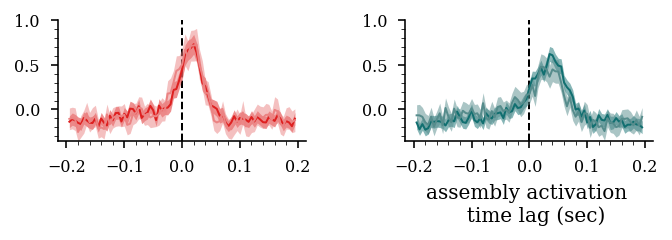

In [26]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=1, subplots=(4, 2)),
    constrained_layout=False,
)
gs = fig.add_gridspec(nrows=5, ncols=2, left=0.05, right=0.75, hspace=0.4, wspace=0.4)

y_min = -0.75
y_max = 1.25
heatmap_factor = 2

time_idx = (post_deep.index > -0.2) & (post_deep.index < 0.2)
post_deep.iloc[time_idx, :]

ax0 = fig.add_subplot(gs[0, 0])
deep_mec_mean = plot_psth_postive_negative(
    post_deep.iloc[time_idx, :],
    meta_data_deep,
    "EC1|EC2|EC3|EC4|EC5|MEC",
    "deep_mec",
    group_colors,
    ax0,
    plot_neg=False,
    return_mean=True,
    smooth_sigma=None,
)
sup_mec_mean = plot_psth_postive_negative(
    post_sup.iloc[time_idx, :],
    meta_data_sup,
    "EC1|EC2|EC3|EC4|EC5|MEC",
    "sup_mec",
    group_colors,
    ax0,
    plot_neg=False,
    return_mean=True,
    smooth_sigma=None,
)

ax1 = fig.add_subplot(gs[0, 1])
deep_pfc_mean = plot_psth_postive_negative(
    post_deep.iloc[time_idx, :],
    meta_data_deep,
    "PFC",
    "deep_pfc",
    group_colors,
    ax1,
    plot_neg=False,
    return_mean=True,
    smooth_sigma=None,
)
sup_pfc_mean = plot_psth_postive_negative(
    post_sup.iloc[time_idx, :],
    meta_data_sup,
    "PFC",
    "sup_pfc",
    group_colors,
    ax1,
    plot_neg=False,
    return_mean=True,
    smooth_sigma=None,
)

axs = [ax0, ax1]
for i in range(2):
    # axs[i].spines["bottom"].set_visible(False)
    # axs[i].axes.get_xaxis().set_ticks([])
    axs[i].axvline(0, linestyle="--", linewidth=1, alpha=1, color="k", zorder=-100)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

ax1.set_xlabel("assembly activation \n  time lag (sec)")
ax0.set_ylim(-0.35, 1)
ax1.set_ylim(-0.35, 1)
sns.despine()

plt.savefig(
    os.path.join(fig_save_path, "downstream_psth_to_ca1_assemblies_just_psth.svg"),
    dpi=300,
    bbox_inches="tight",
)


In [27]:
## with smoothing of 10ms

print("deep_mec lag", post_deep.iloc[time_idx,:].index[np.argmax(deep_mec_mean)])
print("sup_mec lag",post_deep.iloc[time_idx,:].index[np.argmax(sup_mec_mean)])


print("deep_pfc lag", post_deep.iloc[time_idx,:].index[np.argmax(deep_pfc_mean)])
print("sup_pfc lag",post_deep.iloc[time_idx,:].index[np.argmax(sup_pfc_mean)])

deep_mec lag 0.020000000000000018
sup_mec lag 0.025000000000000022
deep_pfc lag 0.03500000000000003
sup_pfc lag 0.020000000000000018


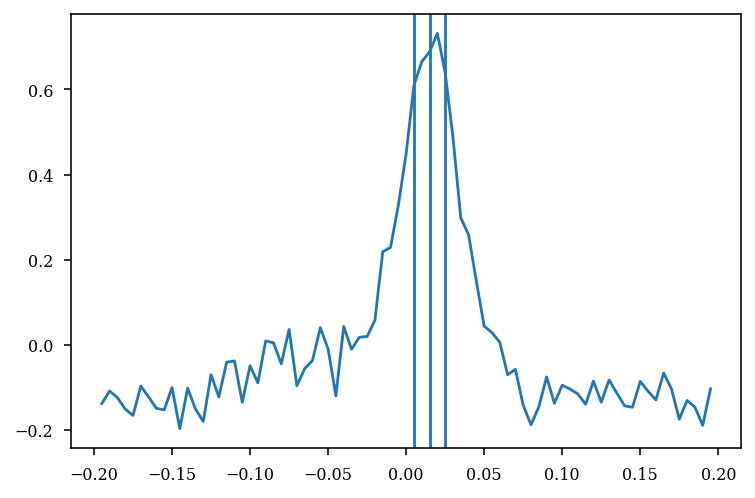

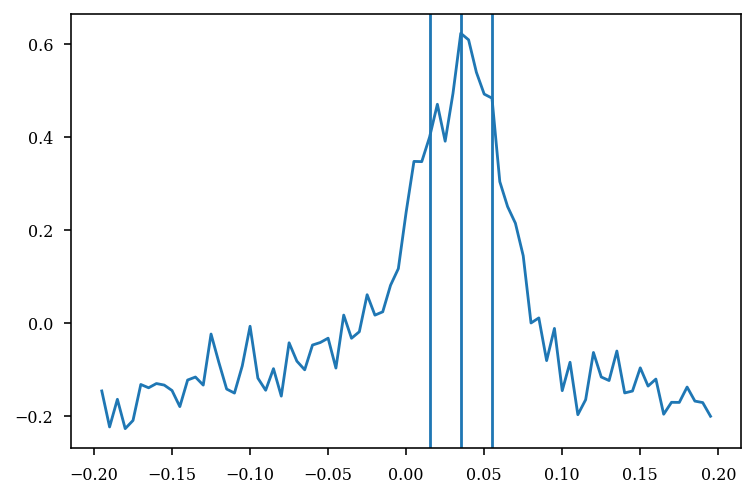

In [67]:
plt.plot(post_deep.iloc[time_idx,:].index,deep_mec_mean)
plt.axvline(0.005)
plt.axvline(0.015)
plt.axvline(0.025)
plt.show()

plt.plot(post_deep.iloc[time_idx,:].index,deep_pfc_mean)
std = 0.02
plt.axvline(0.035-std)
plt.axvline(0.035)
plt.axvline(0.035+std)

In [41]:
post_deep.iloc[time_idx,:].index[np.argmax(deep_mec_mean)]

0.020000000000000018

In [28]:
post_deep.iloc[(post_deep.index > -0.2) & (post_deep.index < 0.2),:]

,0,1,2,3,4,5,6,7,8,9,...,3285,3286,3287,3288,3289,3290,3291,3292,3293,3294
-0.195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,2.173913,0.000000,4.347826,0.000000,0.0,1.086957,0.000000,0.000000
-0.190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,3.260870,0.000000,2.173913,2.173913,0.0,3.260870,0.000000,0.000000
-0.185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.333333,0.000000,2.173913,2.173913,1.086957,0.000000,0.0,0.000000,0.000000,0.000000
-0.180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,3.260870,1.086957,1.086957,1.086957,0.0,1.086957,0.000000,14.285714
-0.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,3.333333,1.086957,0.000000,4.347826,1.086957,0.0,2.173913,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,2.173913,1.086957,2.173913,1.086957,0.0,1.086957,4.761905,0.000000
0.180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,2.173913,2.173913,0.0,1.086957,0.000000,4.761905
0.185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.666667,0.000000,0.000000,3.260870,2.173913,0.000000,0.0,0.000000,0.000000,0.000000
0.190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.666667,0.000000,2.173913,2.173913,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [33]:
def center_peak_val(psth_df,window=[0,0.05],smooth_sigma=0.01):
    psth = stats.zscore(psth_df.values, axis=0)
    # smooth over time
    psth_smooth = gaussian_filter1d(
        psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
    )
    # pull out data within time window
    X = psth_smooth[(psth_df.index > window[0]) & (psth_df.index < window[1]), :]
    # find center value of each cell, can be positive or negative, but will be max magnitude
    center_val = [X[np.argmax(np.abs(X[:,i])),i] for i in range(X.shape[1])]

    return np.array(center_val)

In [34]:
lag_df = pd.DataFrame()
lag = []

peak_val = np.max(post_deep.values,axis=0)
peak_loc = np.argmax(post_deep.values,axis=0)
peak_val_center = center_peak_val(post_deep)
lag_ = np.array(post_deep.index[peak_loc])
lag_[(peak_val == 0) & np.isnan(peak_val) & (peak_val_center<0)] = np.nan
lag.append(lag_)


peak_val = np.max(post_sup.values,axis=0)
peak_loc = np.argmax(post_sup.values,axis=0)
peak_val_center = center_peak_val(post_sup)
lag_ = np.array(post_sup.index[peak_loc])
lag_[(peak_val == 0) & np.isnan(peak_val) & (peak_val_center<0)] = np.nan
lag.append(lag_)

lag_df["lag"] = np.hstack(lag)
lag_df["brainRegion"] = np.hstack([meta_data_deep.brainRegion,meta_data_sup.brainRegion])
lag_df["UID"] = np.hstack([meta_data_deep.UID,meta_data_sup.UID])
lag_df["basepath"] = np.hstack([meta_data_deep.basepath,meta_data_sup.basepath])

lag_df.loc[lag_df.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"),"brainRegion"] = "mec"
lag_df.loc[lag_df.brainRegion.str.contains("PFC"),"brainRegion"] = "pfc"
lag_df["constant"] = 1

<AxesSubplot:xlabel='constant', ylabel='lag'>

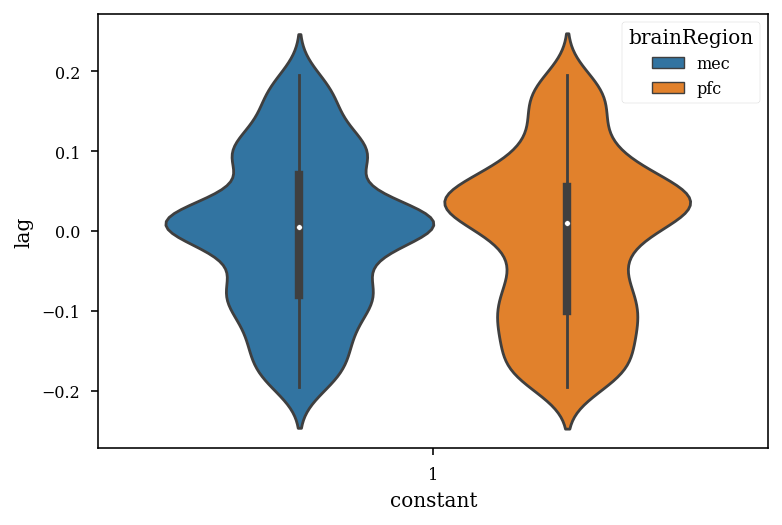

In [35]:
sns.violinplot(data=lag_df.query("lag>-0.2 & lag<0.2"),x="constant",y="lag", hue="brainRegion")

In [51]:
lag_df.query("lag>-0.2 & lag<0.2 & brainRegion == 'mec'").lag.std() / lag_df.query("lag>0 & lag<0.2 & brainRegion == 'mec'").lag.shape[0]

0.0002497847201787122

In [55]:
lag_df.query("lag>-0.20 & lag<0.2 & brainRegion == 'pfc'").lag.std() / lag_df.query("lag>0 & lag<0.2 & brainRegion == 'pfc'").lag.shape[0]


0.10311445101676928

In [54]:
lag_df.query("lag>-0.20 & lag<0.2 & brainRegion == 'pfc'").lag.median()


0.010000000000000009

Text(0.5, 0, 'assembly activation \n  time lag (sec)')

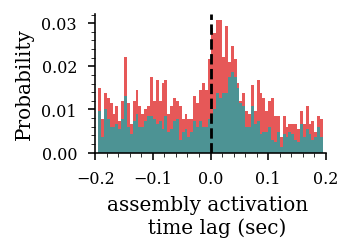

In [130]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(1, 1)), edgecolor=None
)
group_colors = {
    "mec": "#de2020",
    "pfc": "#116f70",
}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.histplot(
    lag_df.query("lag>-0.2 & lag<0.2"),
    x="lag", hue="brainRegion",
    hue_order=group_colors.keys(),
    multiple="stack",
    edgecolor=".3",
    linewidth=0,
    binwidth=.005,
    stat="probability",
    fill=True,
    legend=False
)
plt.axvline(0,color="k",linestyle="--")
sns.despine()
plt.xlim(-0.2,0.2)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlabel('assembly activation \n  time lag (sec)')


In [8]:
np.hstack(
    [
        ["deep_mec"] * len(meta_data_deep.index),
        ["sup_mec"] * len(meta_data_sup.index),
        ["deep_pfc"] * len(meta_data_deep.index),
        ["sup_pfc"] * len(meta_data_sup.index),
    ]
).shape

(8820,)

In [9]:
# plot_psth_postive_negative(post_deep, meta_data_deep, "EC1|EC2|EC3|EC4|EC5|MEC", 'deep_mec', group_colors, ax0)


peak_df = pd.DataFrame()
peak_df["Response magnitude (z)"] = np.hstack(
    [
        get_center_val(post_deep, meta_data_deep, "EC1|EC2|EC3|EC4|EC5|MEC"),
        get_center_val(post_sup, meta_data_sup, "EC1|EC2|EC3|EC4|EC5|MEC"),
        get_center_val(post_deep, meta_data_deep, "PFC"),
        get_center_val(post_sup, meta_data_sup, "PFC"),

    ]
)
# add labels in the most inefficient way possible
peak_df["label"] = np.hstack(
    [
        ["deep-mec"] * len(get_center_val(post_deep, meta_data_deep, "EC1|EC2|EC3|EC4|EC5|MEC")),
        ["sup-mec"] * len(get_center_val(post_sup, meta_data_sup, "EC1|EC2|EC3|EC4|EC5|MEC")),
        ["deep-pfc"] * len(get_center_val(post_deep, meta_data_deep, "PFC")),
        ["sup-pfc"] * len(get_center_val(post_sup, meta_data_sup, "PFC")),
    ]
)
peak_df

,Response magnitude (z),label
0,-0.142494,deep-mec
1,-0.189954,deep-mec
2,NaN,deep-mec
3,NaN,deep-mec
4,0.286302,deep-mec
...,...,...
4405,0.414404,sup-pfc
4406,-0.258599,sup-pfc
4407,-0.226720,sup-pfc
4408,-0.052429,sup-pfc


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

deep-mec vs. sup-mec: Mann-Whitney-Wilcoxon test two-sided, P_val:9.924e-01 U_stat=7.522e+04
deep-pfc vs. sup-pfc: Mann-Whitney-Wilcoxon test two-sided, P_val:1.644e-03 U_stat=1.330e+05


Text(0.5, 1.0, 'positive response')

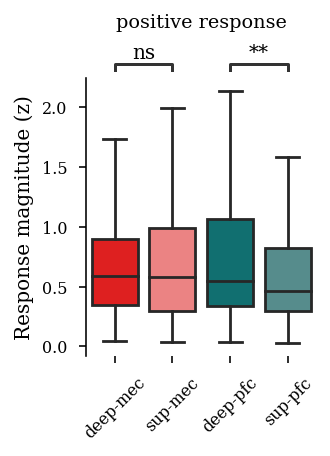

In [10]:
group_colors = {
    "deep-mec": "#de2020",
    "sup-mec": "#eb8383",
    "deep-pfc": "#116f70",
    "sup-pfc": "#568c8c",
}

fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.boxplot(
    x="label",
    y="Response magnitude (z)",
    data=peak_df[peak_df["Response magnitude (z)"] > 0],
    palette=group_colors,
    showfliers=False,
    saturation=1,
)

box_pairs = [
    ("deep-mec", "sup-mec"),
    ("deep-pfc", "sup-pfc"),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=peak_df[peak_df["Response magnitude (z)"] > 0],
    x="label",
    y="Response magnitude (z)",
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()
sns.despine(bottom=True)
plt.xticks(rotation=45)
plt.xlabel("")
plt.title("positive response",pad=25)

# plt.savefig(
#     os.path.join(fig_save_path, "assembly_cortex_response_positive.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

deep-mec vs. sup-mec: Mann-Whitney-Wilcoxon test two-sided, P_val:1.530e-08 U_stat=1.107e+05
deep-pfc vs. sup-pfc: Mann-Whitney-Wilcoxon test two-sided, P_val:2.780e-11 U_stat=6.365e+04


Text(0.5, 1.0, 'negative response')

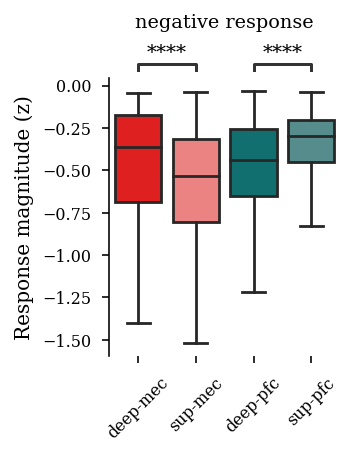

In [11]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.35, subplots=(2, 1)), edgecolor=None
)
sns.boxplot(
    x="label",
    y="Response magnitude (z)",
    data=peak_df[peak_df["Response magnitude (z)"] < 0],
    palette=group_colors,
    showfliers=False,
    saturation=1,
)

box_pairs = [
    ("deep-mec", "sup-mec"),
    ("deep-pfc", "sup-pfc"),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=peak_df[peak_df["Response magnitude (z)"] < 0],
    x="label",
    y="Response magnitude (z)",
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()
sns.despine(bottom=True)
plt.xticks(rotation=45)
plt.xlabel("")
plt.title("negative response",pad=25)

# plt.savefig(
#     os.path.join(fig_save_path, "assembly_cortex_response_negative.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

In [279]:
# sns.boxplot(
#     x="label",
#     y="Response magnitude (z)",
#     data=peak_df[peak_df["Response magnitude (z)"] < 0],
#     palette=group_colors,
#     showfliers=False,
#     saturation=1,
# )
# box_pairs = [
#     ("deep_mec", "sup_mec"),
#     ("deep_pfc", "sup_pfc"),
# ]
# annotator = Annotator(
#     plt.gca(),
#     box_pairs,
#     data=peak_df[peak_df["Response magnitude (z)"] < 0],
#     x="label",
#     y="Response magnitude (z)",
# )
# annotator.configure(
#     test="Mann-Whitney",
#     text_format="star",
#     loc="outside",
#     comparisons_correction=None,
#     verbose=1,
# )
# annotator.apply_and_annotate()
# sns.despine(bottom=True)


## Testing below

In [21]:
meta_data_sup.brainRegion.unique()
pre_sup.shape, meta_data_sup.shape

((201, 3033), (1128, 5))

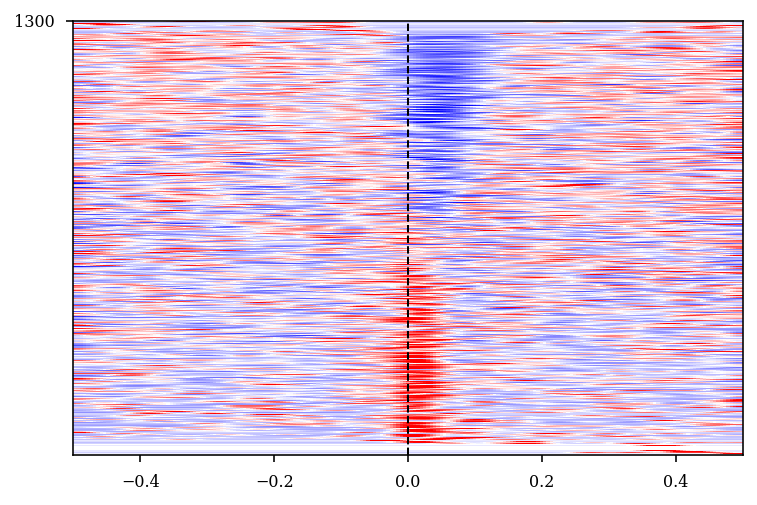

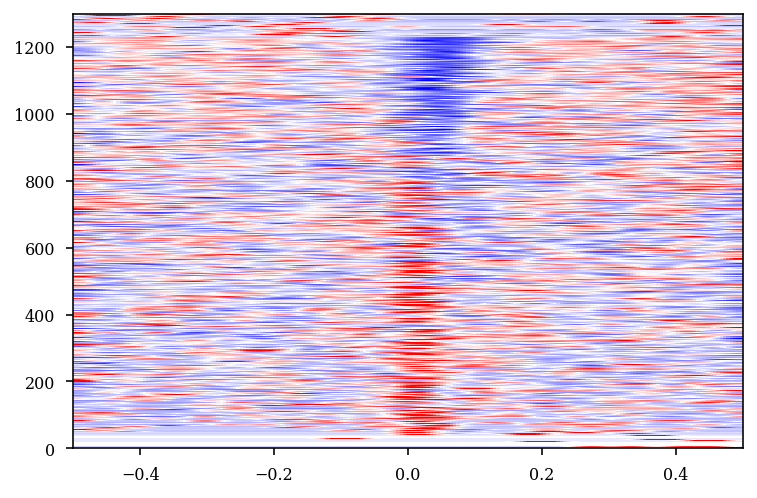

In [37]:
from scipy.ndimage import gaussian_filter1d

psth_df = post_deep.loc[:,meta_data_deep.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").values]

extent = [psth_df.index.min(), psth_df.index.max(), 0, psth_df.shape[1]]
psth = psth_df.values
max_mean_ratio = (psth[(psth_df.index > 0) & (psth_df.index < 0.1),:].max(axis=0) / psth[(psth_df.index < -0.10),:].mean(axis=0))
psth = gaussian_filter1d(psth, np.round(.020 / np.diff(psth_df.index)[0]),axis=0)

sort_idx = np.argsort(max_mean_ratio)

plt.figure()
ax = plt.gca()
sm = ax.imshow(
    stats.zscore(psth, axis=0)[:, sort_idx].T,
    aspect="auto",
    interpolation="nearest",
    extent=extent,
    vmin=-3,
    vmax=3,
    cmap="bwr"
)

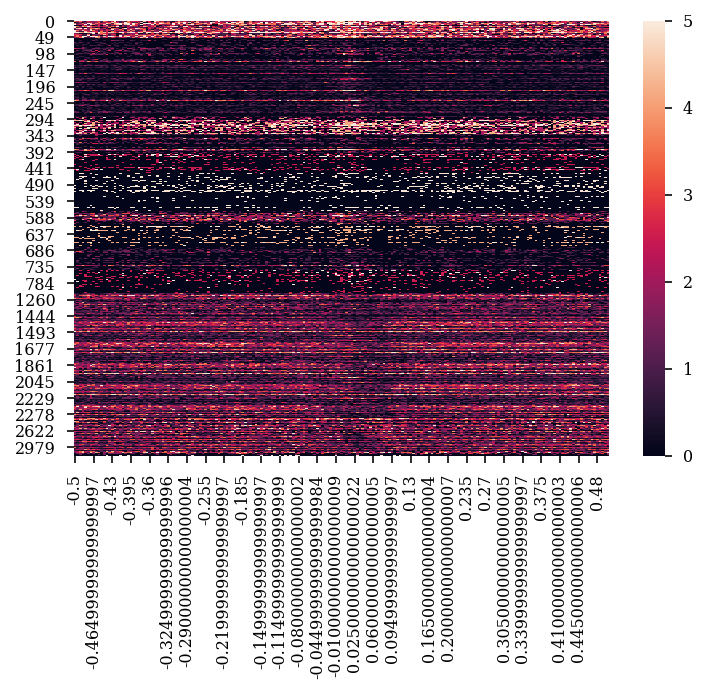

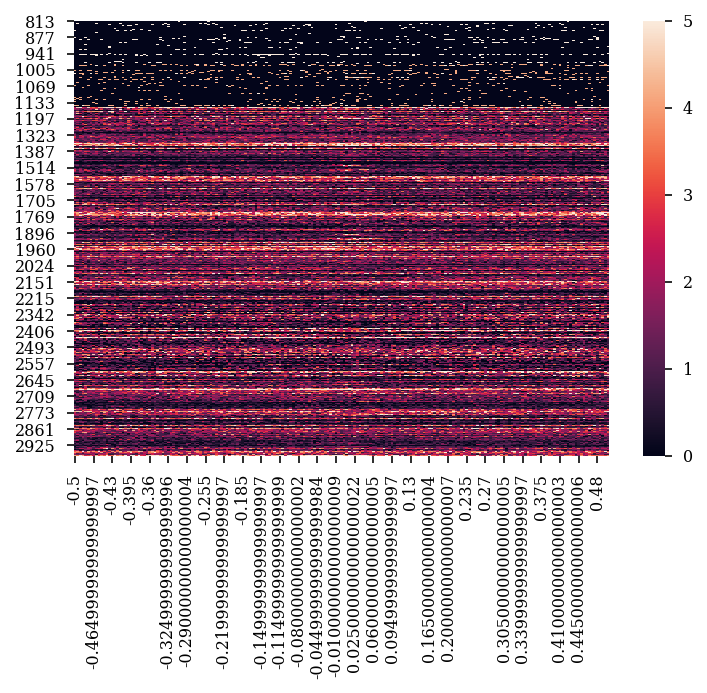

In [26]:
sns.heatmap(post_deep.loc[:,meta_data_deep.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").values].T,vmax=5)
plt.show()

sns.heatmap(post_deep.loc[:,meta_data_deep.brainRegion.str.contains("PFC").values].T,vmax=5)
plt.show()

In [76]:
import pickle

session = r"Z:\home\ryanh\projects\ripple_heterogeneity\ca1_assembly_downstream_psth_v2\Z__Data_HMC1_day13.pkl"
with open(session, "rb") as f:
    results = pickle.load(f)
# results["pre"]["mixed"]

In [87]:
results['cell_metrics'].keys()

Index(['UID', 'ab_ratio', 'acg_asymptote', 'acg_c', 'acg_d', 'acg_fit_rsquare',
       'acg_h', 'acg_refrac', 'acg_tau_burst', 'acg_tau_decay', 'acg_tau_rise',
       'animal', 'brainRegion', 'burstIndex_Doublets',
       'burstIndex_Mizuseki2012', 'burstIndex_Royer2012', 'cellID', 'cluID',
       'cv2', 'deepSuperficial', 'deepSuperficialDistance',
       'deltaWaves_modulationIndex', 'deltaWaves_modulationPeakResponseTime',
       'deltaWaves_modulationSignificanceLevel', 'electrodeGroup',
       'firingRate', 'firingRateCV', 'firingRateGiniCoeff', 'firingRateISI',
       'firingRateInstability', 'maxWaveformCh', 'maxWaveformCh1',
       'maxWaveformChannelOrder', 'peakVoltage', 'peakVoltage_expFit',
       'peakVoltage_expFitLengthConstant', 'phy_amp', 'phy_maxWaveformCh1',
       'polarity', 'population_modIndex', 'putativeCellType', 'rankorder',
       'refractoryPeriodViolation', 'ripple_FRall', 'ripple_FRparticip',
       'ripple_GainAll', 'ripple_GainParticip', 'ripple_nSpkAll'

In [111]:
(results["pre"]["Deep"].shape[1] / results["cell_metrics"].shape[0])

5.0

In [117]:
meta_data_deep = pd.DataFrame()

fields_to_keep = ["UID", "brainRegion", "putativeCellType", "basepath"]

n_assembly = int(results["pre"]["Deep"].shape[1] / results["cell_metrics"].shape[0])

for n_assem in range(n_assembly):

    temp_df = results["cell_metrics"][fields_to_keep].copy()
    temp_df["assembly_n"] = n_assem

    meta_data_deep = pd.concat([meta_data_deep, temp_df], ignore_index=True)
meta_data_deep


,UID,brainRegion,putativeCellType,basepath,assembly_n
0,1,PFC,Pyramidal Cell,Z:\Data\HMC1\day13,0
1,2,PFC,Pyramidal Cell,Z:\Data\HMC1\day13,0
2,3,PFC,Pyramidal Cell,Z:\Data\HMC1\day13,0
3,4,PFC,Pyramidal Cell,Z:\Data\HMC1\day13,0
4,6,PFC,Pyramidal Cell,Z:\Data\HMC1\day13,0
...,...,...,...,...,...
985,540,MEC,Pyramidal Cell,Z:\Data\HMC1\day13,4
986,541,MEC,Pyramidal Cell,Z:\Data\HMC1\day13,4
987,542,MEC,Pyramidal Cell,Z:\Data\HMC1\day13,4
988,546,MEC,Pyramidal Cell,Z:\Data\HMC1\day13,4


In [104]:
results["pre"]["Deep"].shape[1] / results['cell_metrics'].shape[0]

5.0

In [93]:
results["pre"]["Deep"].shape,results["task"]["Deep"].shape,results["post"]["Deep"].shape

((201, 990), (201, 990), (201, 990))

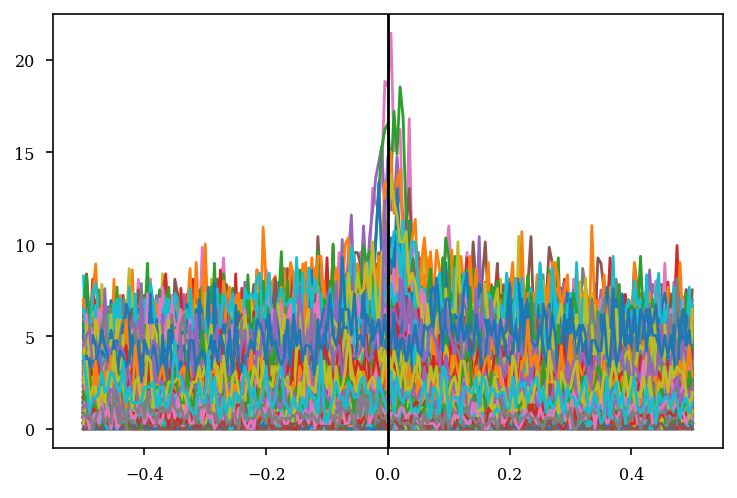

In [80]:
# sns.heatmap(results["post"]["Deep"].T,vmax=3)
# sns.heatmap(results["post"]["Deep"].T,vmax=3)
plt.plot(results["post"]["Deep"])
plt.axvline(0,color='k')
plt.show()

In [ ]:
basepath = r"Z:\Data\FujisawaS\EE\EE0705fm"
ca1_assembly_downstream_psth.run(basepath)

In [93]:
def run(
    basepath,
    regions="CA1",
    target_regions=["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"],
    putativeCellType="Pyr",
    weight_dt=0.1,  # dt in seconds for binning st to get weights for each assembly
    verbose=False,  # print out progress
    rip_exp_start=0.05,  # ripple expansion start, in seconds, how much to expand ripples
    rip_exp_stop=0.05,  # ripple expansion stop, in seconds, how much to expand ripples
):
    """
    Gets the pre and post assembly strengths
    """
    # initialize session
    m1 = assembly_reactivation.AssemblyReact(
        basepath,
        brainRegion=regions,
        putativeCellType=putativeCellType,
        weight_dt=weight_dt,
    )

    # load data
    m1.load_data()

    # extend ripples to include some extra time
    m1.ripples = m1.ripples.expand(rip_exp_start, direction="start")
    m1.ripples = m1.ripples.expand(rip_exp_stop, direction="stop")

    # check if no cells were found
    if m1.cell_metrics.shape[0] == 0:
        return None

    # restrict to pre/task/post epochs
    try:
        m1.restrict_epochs_to_pre_task_post()
    except:
        print("No pre/task/post epochs found")
        return None
    # get weights for task outside ripples
    # % (TODO: use more robust method to locate epochs than index)
    if verbose:
        print("Getting weights...")
    m1.get_weights(m1.epochs[1][~m1.ripples])

    if len(m1.patterns) == 0:
        print("No patterns found")
        return None

    # get assembly activity
    if verbose:
        print("Getting assembly activity...")
    assembly_act_pre = m1.get_assembly_act(epoch=m1.ripples[m1.epochs[0]])
    assembly_act_task = m1.get_assembly_act(epoch=m1.ripples[m1.epochs[1]])
    assembly_act_post = m1.get_assembly_act(epoch=m1.ripples[m1.epochs[2]])
    results = {
        "assembly_act_pre": assembly_act_pre,
        "assembly_act_task": assembly_act_task,
        "assembly_act_post": assembly_act_post,
        "react": m1,
    }

    # get activity for target regions
    st, cell_metrics = loading.load_spikes(
        basepath, brainRegion=target_regions, putativeCellType=putativeCellType
    )
    return results,st,cell_metrics

In [284]:
basepath = r"Z:\Data\FujisawaS\EE\EE0705fm"
# basepath = r"Z:\Data\Kenji\ec013.816_835"
results,st,cell_metrics = run(basepath)

In [285]:
results

{'assembly_act_pre': <AnalogSignalArray at 0x24353801f40: 8 signals (187 segments)> for a total of 31.5324 seconds,
 'assembly_act_task': <AnalogSignalArray at 0x2435acbc7c0: 8 signals (486 segments)> for a total of 1:22:154 minutes,
 'assembly_act_post': <AnalogSignalArray at 0x2435aead430: 8 signals (5 segments)> for a total of 848.0 milliseconds,
 'react': <ripple_heterogeneity.assembly.assembly_reactivation.AssemblyReact at 0x243510da910>}

In [286]:
def get_assembly_df(results, is_member):
    """
    Returns a dataframe of the assembly properties.
    """
    assembly_df = pd.DataFrame()

    patterns = results.get("react").patterns

    assembly_df["patterns"] = patterns.ravel()
    assembly_df["is_member"] = is_member.ravel()
    assembly_df["assembly_n"] = (
        (np.ones_like(patterns).T * np.arange(patterns.shape[0]))
        .T.astype(int)
        .ravel()
    )
    assembly_df["UID"] = np.tile(
        results.get("react").cell_metrics.UID.values, patterns.shape[0]
    )
    assembly_df["putativeCellType"] = np.tile(
        results.get("react").cell_metrics.putativeCellType.values, patterns.shape[0]
    )
    assembly_df["brainRegion"] = np.tile(
        results.get("react").cell_metrics.brainRegion.values, patterns.shape[0]
    )
    assembly_df["deepSuperficial"] = np.tile(
        results.get("react").cell_metrics.deepSuperficial.values, patterns.shape[0]
    )
    assembly_df["deepSuperficialDistance"] = np.tile(
        results.get("react").cell_metrics.deepSuperficialDistance.values,
        patterns.shape[0],
    )
    assembly_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(
        assembly_df
    )
    return assembly_df

In [302]:
# assembly_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(assembly_df)
patterns, is_member_sig, keep_assembly, is_member = find_sig_assembly.main(
    results.get("react").patterns
)
assembly_df = get_assembly_df(results, is_member)
# assembly_df

for assembly_n in assembly_df.assembly_n.unique():
    if (assembly_df[assembly_df.assembly_n == assembly_n].deepSuperficial == "Deep").all():
        assembly_df.loc[assembly_df.assembly_n == assembly_n, "assembly_label"] = "Deep"
    elif (assembly_df[assembly_df.assembly_n == assembly_n].deepSuperficial == "Superficial").all():
        assembly_df.loc[assembly_df.assembly_n == assembly_n, "assembly_label"] = "Superficial"
    else:
        assembly_df.loc[assembly_df.assembly_n == assembly_n, "assembly_label"] = "mixed"

assembly_df

,patterns,is_member,assembly_n,UID,putativeCellType,brainRegion,deepSuperficial,deepSuperficialDistance,assembly_label
0,-0.350531,True,0,248,Pyramidal Cell,CA1,Superficial,80.257363,mixed
1,-0.088265,False,0,249,Pyramidal Cell,CA1,Superficial,40.257363,mixed
2,-0.083125,False,0,253,Pyramidal Cell,CA1,middle,-19.742637,mixed
3,-0.160046,False,0,255,Pyramidal Cell,CA1,Superficial,52.404543,mixed
4,0.022411,False,0,257,Pyramidal Cell,CA1,Deep,-47.595457,mixed
...,...,...,...,...,...,...,...,...,...
379,-0.078158,False,7,335,Pyramidal Cell,CA1,Deep,-140.000000,mixed
380,-0.048938,False,7,343,Pyramidal Cell,CA1,Deep,-120.000000,mixed
381,0.106142,False,7,345,Pyramidal Cell,CA1,Deep,-140.000000,mixed
382,-0.367729,True,7,347,Pyramidal Cell,CA1,Deep,-140.000000,mixed


In [292]:
# cell_metrics = loading.load_all_cell_metrics(df.basepath)

In [303]:
# cell_metrics[np.isnan(cell_metrics.deepSuperficialDistance) & cell_metrics.brainRegion.str.contains("CA1")][["UID","basepath","deepSuperficial","deepSuperficialDistance","brainRegion","putativeCellType"]]

In [153]:
import warnings
warnings.filterwarnings("ignore")
def get_strength_matrix(analog_signal):
    """
    Returns a matrix of the strength of the signal at each timepoint.
    input:
        analog_signal: a nelpy AnalogSignalArray of the assembly strengths, must have segments
    output:
        strength_matrix: a numpy array of the strength of the signal at each timepoint
    """
    strength = np.zeros([analog_signal.n_signals, analog_signal.n_intervals])
    time = strength.copy()
    for rip_i, rip in enumerate(analog_signal):
        strength[:, rip_i] = rip.max()
        time[:, rip_i] = rip.abscissa_vals[np.argmax(rip.data,axis=1)]
    return strength, time

In [154]:
strength, time = get_strength_matrix(results.get("assembly_act_pre"))

In [333]:
def get_psths(
    st,
    assembly_strengths,
    labels=["Deep", "Superficial", "mixed"],
    assembly_strength_thres=5,
    bin_width=0.005,
    n_bins=200,
):
    """
    Returns a dict of the PSTH of st relative to when the assembly is active.
    input:
        st: a nelpy SpikeTrainArray of the st of the assembly
        assembly_strengths: a nelpy analogsignal array of the strength of the signal at each ripple
        labels: a list of the labels of the assemblies
        assembly_strength_thres: the threshold for the strength of the assembly
        bin_width: the width of the bins in seconds
        n_bins: the number of bins
    output:
        psths: a dict of the PSTH of st relative to when the assembly is active
    """
    psths = {}
    for label in labels:
        psth = pd.DataFrame()
        # get the max value and time of max value for each assembly over ripples
        strength, time = get_strength_matrix(assembly_strengths)

        # keep the assemblies that are specific to the label
        assembly_n = assembly_df[
            assembly_df.assembly_label == label
        ].assembly_n.unique()

        strength = strength[assembly_n, :]
        time = time[assembly_n, :]

        # iterate over the assemblies and calculate the psth relative to the time of max strength
        for i in range(strength.shape[0]):
            psth = pd.concat(
                [
                    psth,
                    functions.compute_psth(
                        st.data,
                        time[i, (strength[i, :] > assembly_strength_thres)],
                        bin_width=bin_width,
                        n_bins=n_bins,
                    ),
                ],
                ignore_index=True,
            )
        # add the psth to the dict
        psths[label] = psth
    return psths

psths = get_psths(
    st,
    results.get("assembly_act_pre"),
    assembly_df
)
# assembly_df[assembly_df.assembly_label == "Deep"].assembly_n.unique()
# assembly_df[assembly_df.assembly_label == "Superficial"].assembly_n.unique()
# assembly_df[assembly_df.assembly_label == "mixed"].assembly_n.unique()

# strength = strength[assembly_df[assembly_df.assembly_label == "mixed"].assembly_n.unique(),:]
# time = time[assembly_df[assembly_df.assembly_label == "mixed"].assembly_n.unique(),:]


In [331]:
psths.get("Superficial")

""


In [249]:
psth = []
for i in range(strength.shape[0]):
    psth.append(functions.compute_psth(
        st.data, time[i, (strength[i, :] > 5)], bin_width=0.005, n_bins=200
    ))

In [252]:
psth[0]

,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
-0.500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.298851,0.000000,0.000000,0.0,...,0.000000,0.000000,2.298851,4.597701,0.0,0.0,0.0,0.000000,0.000000,2.298851
-0.495,0.000000,0.000000,0.000000,0.000000,0.000000,4.597701,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,6.896552,0.0,0.0,0.0,2.298851,0.000000,2.298851
-0.490,0.000000,2.298851,0.000000,2.298851,0.000000,4.597701,0.000000,0.000000,2.298851,0.0,...,0.000000,0.000000,0.000000,2.298851,0.0,0.0,0.0,0.000000,0.000000,0.000000
-0.485,0.000000,0.000000,0.000000,0.000000,0.000000,2.298851,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,2.298851,2.298851,0.0,0.0,0.0,0.000000,0.000000,0.000000
-0.480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.298851,0.000000,0.0,...,0.000000,0.000000,2.298851,2.298851,0.0,0.0,0.0,0.000000,0.000000,2.298851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.480,0.000000,2.298851,0.000000,2.298851,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,2.298851,0.000000,2.298851,0.0,0.0,0.0,0.000000,2.298851,9.195402
0.485,0.000000,2.298851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,2.298851,2.298851,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.298851
0.490,0.000000,0.000000,0.000000,2.298851,0.000000,2.298851,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,2.298851,2.298851,0.0,0.0,0.0,0.000000,0.000000,2.298851
0.495,2.298851,0.000000,2.298851,0.000000,4.597701,2.298851,0.000000,0.000000,0.000000,0.0,...,0.000000,2.298851,0.000000,6.896552,0.0,0.0,0.0,2.298851,0.000000,2.298851


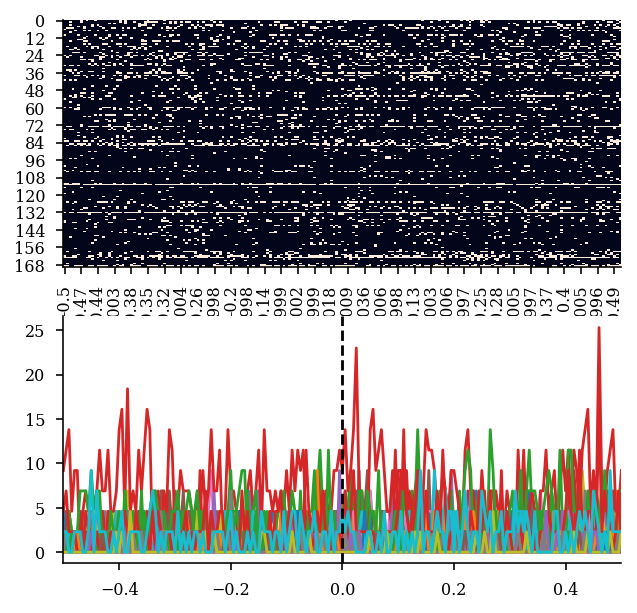

In [246]:
assembly_n = 0
idx = (strength[assembly_n,:] > 5)

psth = functions.compute_psth(st.data, time[assembly_n,idx], bin_width=0.005, n_bins=200)
fig, ax = plt.subplots(2,1,figsize=(5,5))
sns.heatmap(psth.T,ax=ax[0],cbar=False,vmin=0,vmax=2)
ax[1].plot(psth)
ax[1].axvline(0, color="k", linestyle="--")
ax[1].set_xlim(-.5,.5)
sns.despine()
plt.show()

In [156]:
results.get("react").st

<SpikeTrainArray at 0x24357287d60: 48 units> at 20000 Hz

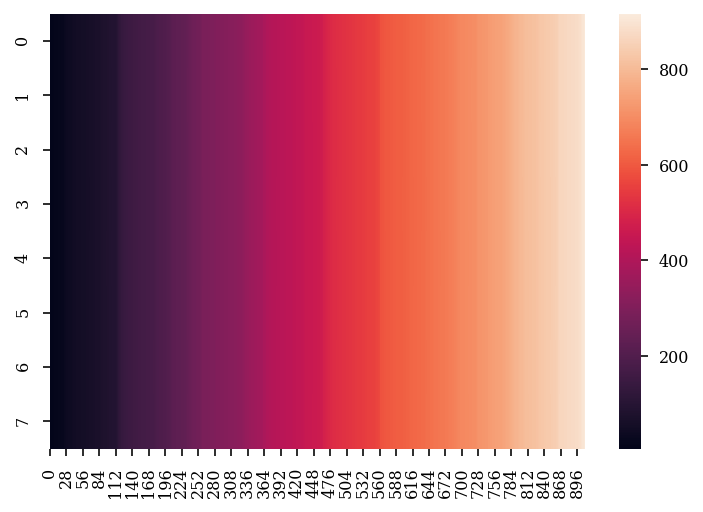

In [157]:
sns.heatmap(np.array(time))
plt.show()

In [158]:
idx = np.argmax(results.get("assembly_act_pre")[1].data,axis=1)
results.get("assembly_act_pre")[1].abscissa_vals[idx]

array([6.4142, 6.4142, 6.2194, 6.5242, 6.2434, 6.3782, 6.2294, 6.5462])

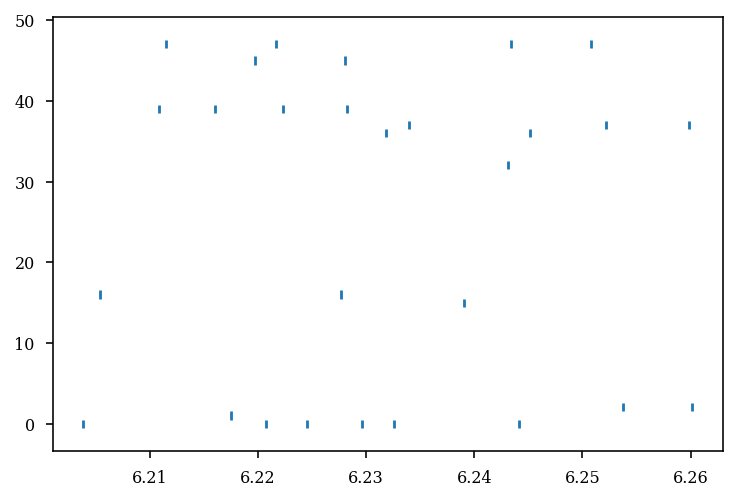

In [159]:
plt.eventplot(results.get("react").st[results.get("react").ripples[1][results.get("react").epochs[0]]].data)
plt.show()

In [ ]:
rip = 25
results.get("react").st[results.get("react").ripples[rip][results.get("react").epochs[0]]].data

In [161]:
import nelpy as nel

current_epoch = nel.EpochArray(
    np.array(
        [
            results.get("assembly_act_pre")[rip].abscissa_vals.min(),
            results.get("assembly_act_pre")[rip].abscissa_vals.max(),
        ]
    )
)


In [166]:
results.get("assembly_act_task")

<AnalogSignalArray at 0x24355b4e0a0: 8 signals (1,803 segments)> for a total of 5:24:101 minutes

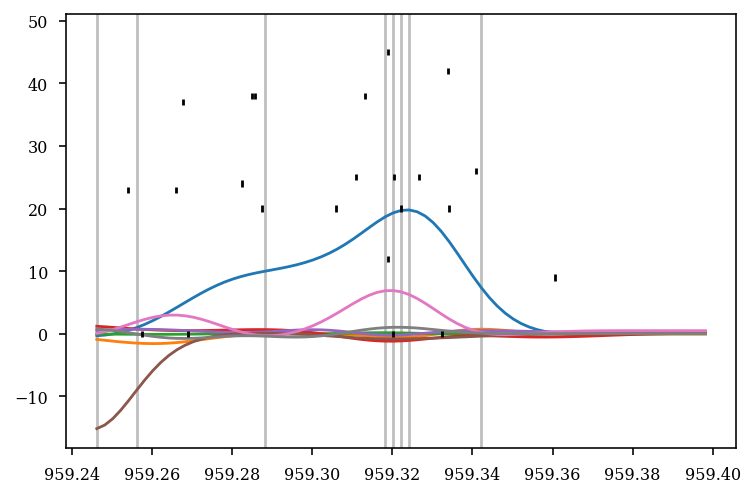

In [178]:
rip = 62
idx = np.argmax(results.get("assembly_act_task")[rip].data,axis=1)

plt.plot(results.get("assembly_act_task")[rip].abscissa_vals, results.get("assembly_act_task")[rip].data.T)
for val in results.get("assembly_act_task")[rip].abscissa_vals[idx]:
    plt.axvline(val, color="grey",alpha=.5,zorder=-1000)

# [results.get("react").epochs[0]]]
current_epoch = nel.EpochArray(
    np.array(
        [
            results.get("assembly_act_task")[rip].abscissa_vals.min(),
            results.get("assembly_act_task")[rip].abscissa_vals.max(),
        ]
    )
)
plt.eventplot(results.get("react").st[current_epoch].data,color="k")

plt.show()

In [14]:

get_strength_matrix(results.get("assembly_act_pre"))

<AnalogSignalArray at 0x2434e557250: 8 signals (121 segments)> for a total of 21.5256000000000001 seconds